# Workshop on Time Series : Arctic Ice Coverage

Analysis of fluctuations of Arctic ice coverage

## Package imports and definition of functions

In [ ]:
pip install statsmodels==0.12.0

In [ ]:
import calendar
# import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import scipy.stats as st

# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error #r2_score, median_absolute_error, 
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


# import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf



# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# import warnings
# warnings.simplefilter(action='ignore')

In [ ]:
### https://ipython.readthedocs.io/en/stable/api/generated/IPython.utils.text.html#classes

pip_list = !pip list
pip_dict = dict(zip(pip_list.fields(0), pip_list.fields(1)))
print(pip_dict['seaborn'])

pyth = !python --version
pyth_on = pyth[0][7:]
print(pyth, pyth_on)

0.11.2
['Python 3.7.12'] 3.7.12


In [ ]:
used_versions = [["python", "3.7.12", pyth_on],  
                 ["matplotlib", "3.2.2", pip_dict['matplotlib']], 
                 ["numpy", "1.19.5", pip_dict['numpy']], 
                 ["pandas", "1.4.1", pip_dict['scipy']],
                 ["scipy", "1.4.1", pip_dict['scipy']],
                 ["seaborn", "0.11.2", pip_dict['seaborn']],
                 ["sklearn", "0.22.2.post1", pip_dict['scikit-learn']],
                 ["statsmodels", "0.12.0", pip_dict['statsmodels']]
                 ]

versions = pd.DataFrame(used_versions)
versions.columns = ["package", "my_versions", 'your_versions']
versions['coincidence'] = ( versions['your_versions'] == versions['my_versions'])
print("The project was written and run within following environment:")
versions

The project was written and run within following environment:


,package,my_versions,your_versions,coincidence
0,python,3.7.12,3.7.12,True
1,matplotlib,3.2.2,3.2.2,True
2,numpy,1.19.5,1.19.5,True
3,pandas,1.4.1,1.4.1,True
4,scipy,1.4.1,1.4.1,True
5,seaborn,0.11.2,0.11.2,True
6,sklearn,0.22.2.post1,0.22.2.post1,True
7,statsmodels,0.12.0,0.12.0,True


In [ ]:
# RANDOM_STATE = 31415926



### Plotting

plt.rcParams["figure.figsize"] = (18, 8)

# sns.set(style='whitegrid', palette="bright")
sns.set_theme()
sns.set(font_scale = 1.25)

FONT_SIZE=14

# plt.style.use('seaborn')

## EDA and Data wrangling

In [ ]:
# Choose the location: 'colab' or 'local'
location = 'colab'

if location == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')
    FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/DS_EPAM Basic course/Time Series/"
elif location == 'local':
    # FILE_PATH = "./DS_EPAM_basic_course"
    FILE_PATH = ""
else:
    print("Please choose the location: 'colab' or 'local'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read data

In [ ]:
### downloaded 29 Aug 2021
### https://nsidc.org/arcticseaicenews/sea-ice-tools/
## NH, SH correspond to north and south hemispheres, respectively

filename = "Sea_Ice_Index_Monthly_Data_with_Statistics_G02135_v3.0.xlsx"


data = pd.read_excel(FILE_PATH + filename, 
                     sheet_name=2, 
                     skiprows=9, header=0)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        43 non-null     int64  
 1   year                              43 non-null     int64  
 2   month                             43 non-null     int64  
 3   data-type                         43 non-null     object 
 4   hemisphere                        43 non-null     object 
 5   extent                            43 non-null     float64
 6   area                              43 non-null     float64
 7   rank                              43 non-null     float64
 8   extent-anomaly                    43 non-null     float64
 9   trend-through-year-km^2-per-year  42 non-null     float64
 10  p-value                           42 non-null     float64
 11  r-value                           43 non-null     float64
 12  stderr    

In [ ]:
print(data.shape)
print(data.columns)
data.head()

(43, 19)
Index(['Unnamed: 0', 'year', 'month', 'data-type', 'hemisphere', 'extent',
       'area', 'rank', 'extent-anomaly', 'trend-through-year-km^2-per-year',
       'p-value', 'r-value', 'stderr', 'significant', '%-trend-through-year',
       ' reordered => ', 'ordered-rank', 'ranked-year', 'ranked-extent'],
      dtype='object')


,Unnamed: 0,year,month,data-type,hemisphere,extent,area,rank,extent-anomaly,trend-through-year-km^2-per-year,p-value,r-value,stderr,significant,%-trend-through-year,reordered =>,ordered-rank,ranked-year,ranked-extent
0,0,1979,3,Goddard,N,16.34,13.21,43.0,0.912,NaN,NaN,0.000,NaN,0,NaN,,1.0,2017,14.29
1,1,1980,3,Goddard,N,16.04,12.99,40.5,0.612,-300000.0,0.000,-1.000,0.000,1,-19.446,,2.0,2018,14.30
2,2,1981,3,Goddard,N,15.63,12.71,33.0,0.202,-355000.0,0.057,-0.996,0.032,0,-23.011,,3.0,2015,14.37
3,3,1982,3,Goddard,N,16.04,13.07,40.5,0.612,-131000.0,0.420,-0.580,0.130,0,-8.491,,4.0,2016,14.40
4,4,1983,3,Goddard,N,16.09,12.93,42.0,0.662,-50000.0,0.612,-0.310,0.088,0,-3.241,,5.0,2006,14.42


Keep only target and timemarks.

In [ ]:
data_full = pd.DataFrame()


for k in range(0, 12):
    pd.read_excel(FILE_PATH + filename, sheet_name=k)

    data = pd.read_excel(FILE_PATH + filename, 
                     sheet_name=k, 
                     skiprows=9, header=0)
    # print(k, data.shape)
    # display(data.head(3))
    # data = data[['year', 'month', 'extent', 'area']]
    data = data[['year', 'month', 'extent']]
    data_full = data_full.append(data)

data_full = data_full.reset_index(drop=True)

# display(data_full.head(3))
# display(data_full.tail(3))
data_full

,year,month,extent
0,1979,1,15.41
1,1980,1,14.86
2,1981,1,14.91
3,1982,1,15.18
4,1983,1,14.94
...,...,...,...
508,2016,12,11.46
509,2017,12,11.74
510,2018,12,11.86
511,2019,12,11.90


Check duplicates.

In [ ]:
print(f"We have {data_full.duplicated().sum()} duplicates.")

We have 0 duplicates.


Check nans.

In [ ]:
# print(data_full.shape)
# display(data_full.info())
print("\nNans in the dataframe:")
display(data_full.isna().sum())


Nans in the dataframe:


year      0
month     0
extent    2
dtype: int64

We have nans in target.

Create timemarks and drop lasr row (maybe this data are not complete).

In [ ]:
data_full['date'] = data_full['year'].astype('str') + "-" + data_full['month'].astype('str') + "-15"
data_full['date'] = pd.to_datetime(data_full['date'], format="%Y-%m-%d")
data_full = data_full.sort_values("date").reset_index(drop=True)

# drop last row, maybe this data are not complete
data_full = data_full.drop(len(data_full)-1, axis=0)
data_full

,year,month,extent,date
0,1978,11,11.65,1978-11-15
1,1978,12,13.67,1978-12-15
2,1979,1,15.41,1979-01-15
3,1979,2,16.18,1979-02-15
4,1979,3,16.34,1979-03-15
...,...,...,...,...
507,2021,2,14.39,2021-02-15
508,2021,3,14.64,2021-03-15
509,2021,4,13.84,2021-04-15
510,2021,5,12.66,2021-05-15


In [ ]:
data = data_full[['date', 'extent']]
data = data.set_index(pd.DatetimeIndex(data['date']))
data = data.drop(['date'], axis=1)
data

,extent
date,
1978-11-15,11.65
1978-12-15,13.67
1979-01-15,15.41
1979-02-15,16.18
1979-03-15,16.34
...,...
2021-02-15,14.39
2021-03-15,14.64
2021-04-15,13.84


### Imputation of missing values

In [ ]:
data_full.loc[data_full.isna().sum(axis=1)>0, :]

,year,month,extent,date
109,1987,12,NaN,1987-12-15
110,1988,1,NaN,1988-01-15


Impute nans using linear interpolation.

In [ ]:
extent_imputed = ( data['extent'].fillna(method='bfill') + data['extent'].fillna(method='ffill'))/2
index_to_impute = data[data.isna().sum(axis=1)>0].index
data.loc[index_to_impute, 'extent'] = extent_imputed

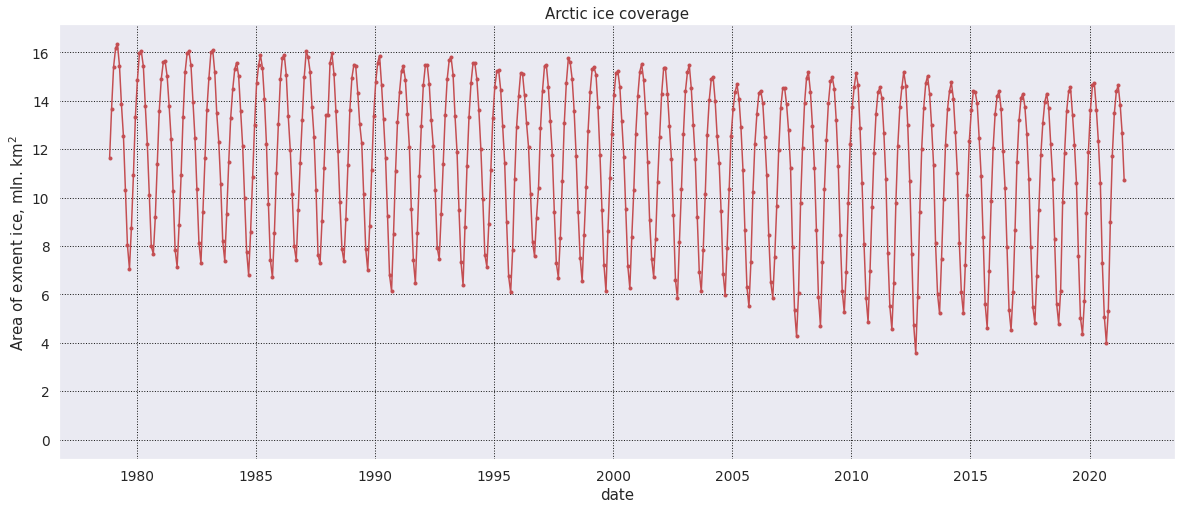

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))

plt.plot(data, '-ro', markersize=3)
plt.plot(data.index[0], 0)

plt.grid(linestyle=':', color='k')
plt.title("Arctic ice coverage")
plt.xlabel("date")
plt.ylabel("Area of exnent ice, mln. km$^2$")
plt.show()

### Test for stationarity

Let us check the time dependence of target for stationarity using two tests - Augmented Dickey–Fuller (ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test. The information about them with details can be found here:

* ADF - https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
* KPSS - https://en.wikipedia.org/wiki/KPSS_test

In [ ]:
alpha = 0.05
print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(data['extent'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
  print("The process is stationary.\n")
else:
  print("The process is non-stationary.\n")  

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -0.9387977936472521
p-value: 0.7749274751238511
The process is non-stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(data['extent'], regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
  print("The process is non-stationary.\n")
else:
  print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 1.5871866581062943
p-value = 0.01
The process is non-stationary.



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


### Time Series Decomposition

Perform decomposition procedure assuming that
* components are additive 
* we have year-periodic component

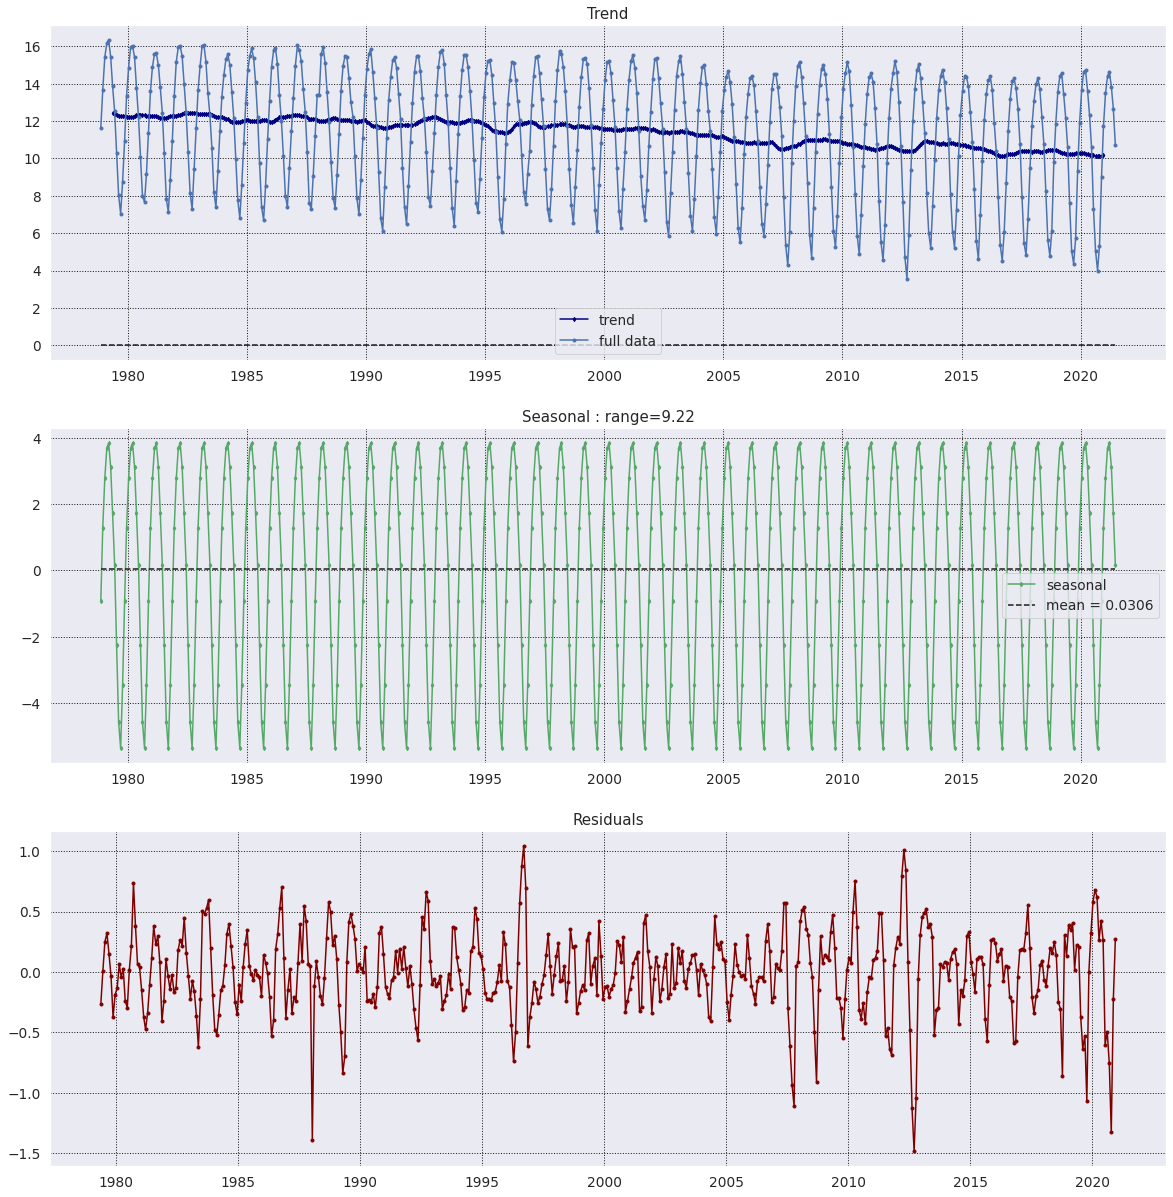

In [ ]:
decomposition = seasonal_decompose(data['extent'], model='additive', period=12)



plt.subplots(3, 1, figsize=(20, 21))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, 
         '-d', color='navy', markersize=3, label='trend')
plt.plot(data, '-bo', markersize=3, label='full data')
# plt.plot(decomposition.trend.index[0], 0)
plt.plot([decomposition.trend.index[0], decomposition.trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")


plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, 
         '-gd', markersize=3, label='seasonal')
plt.plot([decomposition.seasonal.index[0], decomposition.seasonal.index[-1]], 
         decomposition.seasonal.mean()*np.array([1, 1]), '--k', 
         label=f"mean = {decomposition.seasonal.mean():.3g}")
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title(f"Seasonal : range={(decomposition.seasonal.max() - decomposition.seasonal.min()):.3g}")


plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, '-o', color='maroon', markersize=3)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")
plt.show()

#### *Analysis of decomposition residuals*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


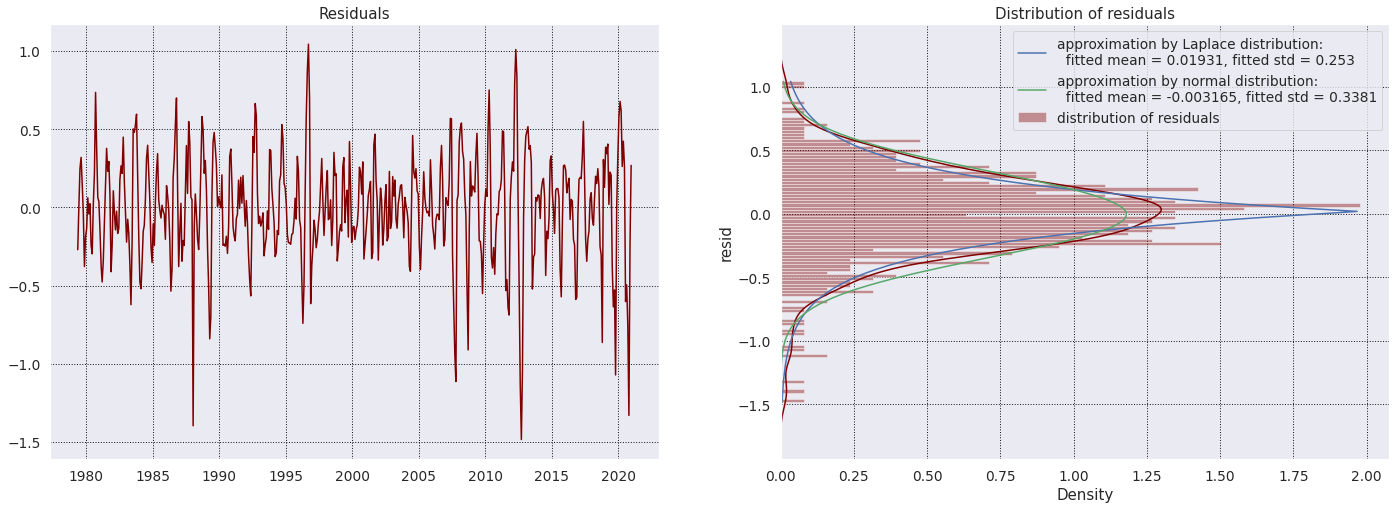

In [ ]:
resid = decomposition.resid
color = 'maroon'

plt.subplots(1, 2, figsize=(24, 8))

plt.subplot(1, 2, 1)
plt.plot(resid, '-', color=color)
plt.grid(linestyle=':', color='k')
plt.title("Residuals")



x_fit = np.linspace(resid.min(), resid.max(), 201)
loc_laplace, scale_laplace = st.laplace.fit(resid.dropna())
loc_norm, scale_norm = st.norm.fit(resid.dropna())
# print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc:.3f}, fitted std = {scale:.3f}")
y_fit_laplace = st.laplace.pdf(x_fit, loc_laplace, scale_laplace)
y_fit_norm = st.norm.pdf(x_fit, loc_norm, scale_norm)

plt.subplot(1, 2, 2)
sns.distplot(resid, color=color, bins=100, vertical=True, label="distribution of residuals")
plt.plot(y_fit_laplace, x_fit, '-b', 
         label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
plt.plot(y_fit_norm, x_fit, '-g', 
         label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
plt.legend()
# plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
plt.title("Distribution of residuals")
plt.grid(linestyle=':', color='k')

plt.show()

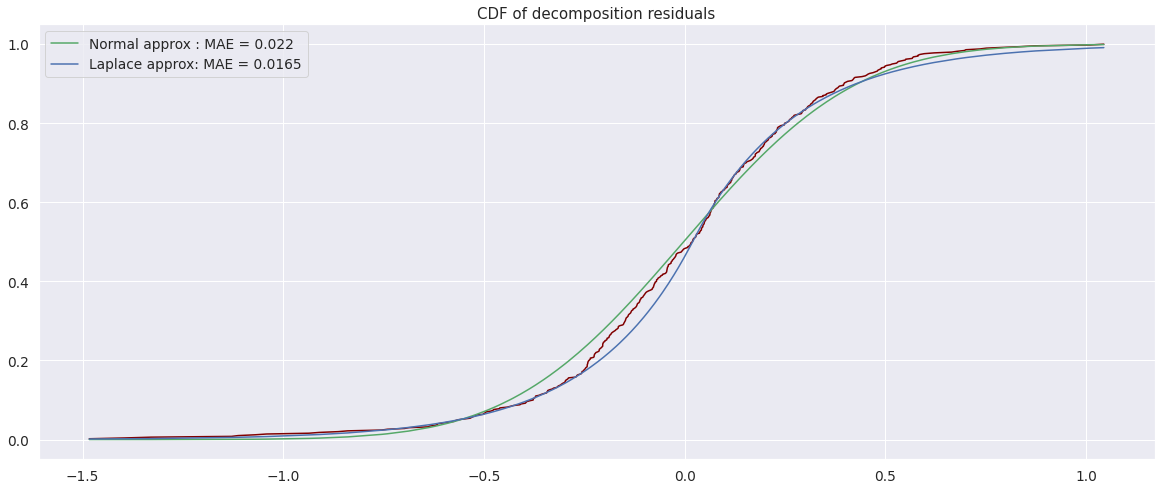

1.3357875384955267


In [ ]:
ecdf_resid_instance = ECDF(resid.dropna())
resid_arr = resid.dropna().sort_values().values
ecdf_resid = ecdf_resid_instance(resid_arr)


cdf_norm = st.norm.cdf(resid_arr, loc=loc_norm, scale=scale_norm)
cdf_laplace = st.laplace.cdf(resid_arr, loc=loc_laplace, scale=scale_laplace)


mae_norm = mean_absolute_error(ecdf_resid, cdf_norm)
mae_laplace = mean_absolute_error(ecdf_resid, cdf_laplace)


plt.subplots(1, 1, figsize=(20, 8))
plt.plot(resid_arr, ecdf_resid, '-', color='maroon')
plt.plot(resid_arr, cdf_norm, '-g', 
         label=f"Normal approx : MAE = {mae_norm:.3g}")
plt.plot(resid_arr, cdf_laplace, '-b', 
         label=f"Laplace approx: MAE = {mae_laplace:.3g}")
plt.legend()
plt.title("CDF of decomposition residuals")
plt.show()

print(mae_norm/mae_laplace)

I believe that errors have Laplace distribution. Therefore I will use MAE as metrics.

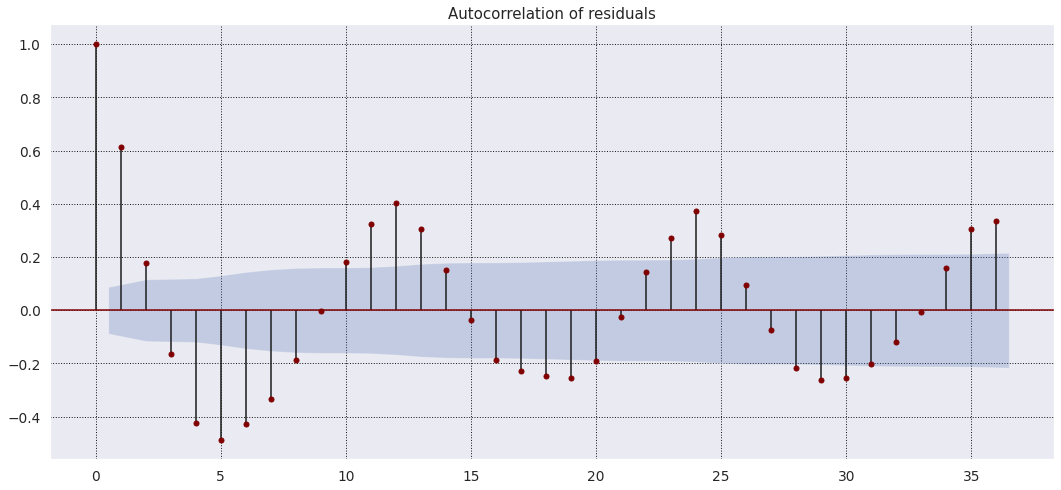

In [ ]:
lags = 36

plot_acf(resid.dropna(), lags=lags, color='maroon', 
         title='Autocorrelation of residuals');
plt.grid(linestyle=':', color='k')

#### *Test for trend stationarity*

In [ ]:
trend = decomposition.trend.dropna()

In [ ]:
alpha = 0.05


print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(trend.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
  print("The process is stationary.\n")
else:
  print("The process is non-stationary.\n") 

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -0.35888274278110033
p-value: 0.9167408549640474
The process is non-stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(trend.dropna(), regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
  print("The process is non-stationary.\n")
else:
  print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 2.623506291285574
p-value = 0.01
The process is non-stationary.



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


Text(0.5, 1.0, 'Trend')

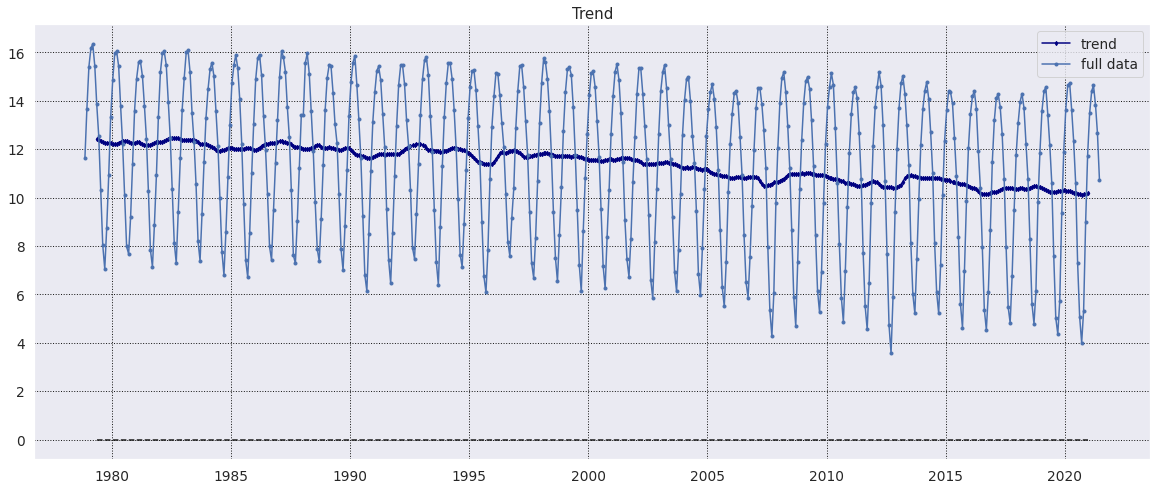

In [ ]:
plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend, '-d', color='navy', markersize=3, label='trend')
plt.plot(data, '-bo', markersize=3, label='full data')
# plt.plot(decomposition.trend.index[0], 0)
plt.plot([trend.index[0], trend.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("Trend")

Let us differentiate trend to get rid of non-stationarity and perform analysis of 1st derivative of trend.

Text(0.5, 1.0, '1st derivative of trend')

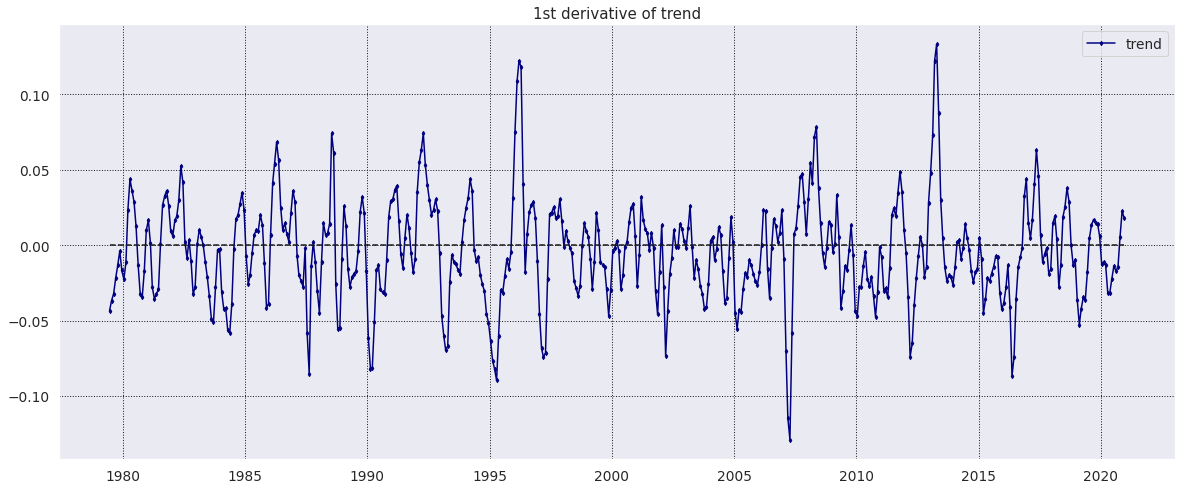

In [ ]:
trend_diff = trend.diff().dropna()

plt.subplots(1, 1, figsize=(20, 8))

plt.plot(trend_diff, '-d', color='navy', markersize=3, label='trend')
plt.plot([trend_diff.index[0], trend_diff.index[-1]], [0, 0], '--k')
plt.legend()
plt.grid(linestyle=':', color='k')
plt.title("1st derivative of trend")

In [ ]:
alpha = 0.05


print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
result = adfuller(trend_diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < alpha:
  print("The process is stationary.\n")
else:
  print("The process is non-stationary.\n") 

alpha = 0.05

==== Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -4.823969573153941
p-value: 4.892561169621748e-05
The process is stationary.



In [ ]:
print('==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
# kpss test
kpsstest = kpss(trend_diff, regression='c')
print("KPSS Statistic = " + str(kpsstest[0]))
print( "p-value = " +str(kpsstest[1]))
if kpsstest[1] < alpha:
  print("The process is non-stationary.\n")
else:
  print("The process is stationary.\n")

==== Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.03336818030607312
p-value = 0.1
The process is stationary.



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


### Correlation Analysis

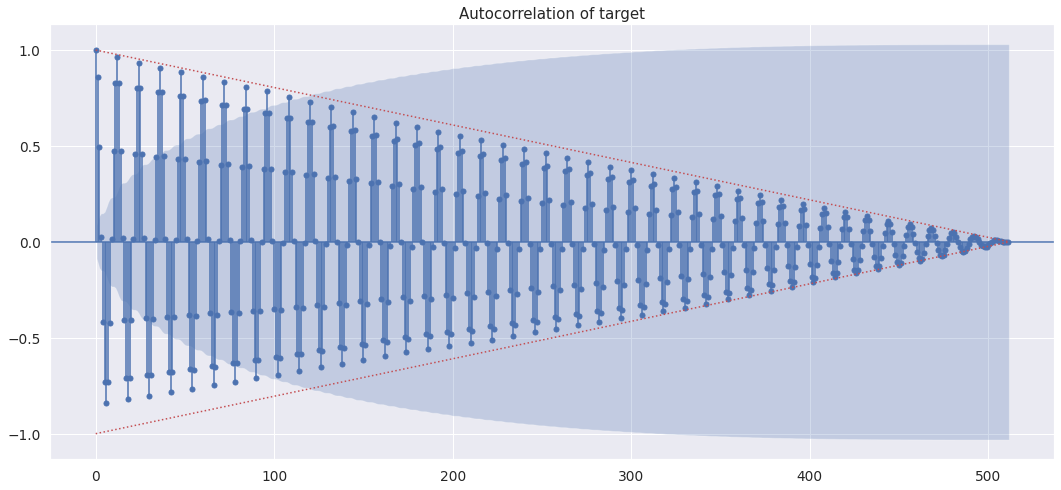

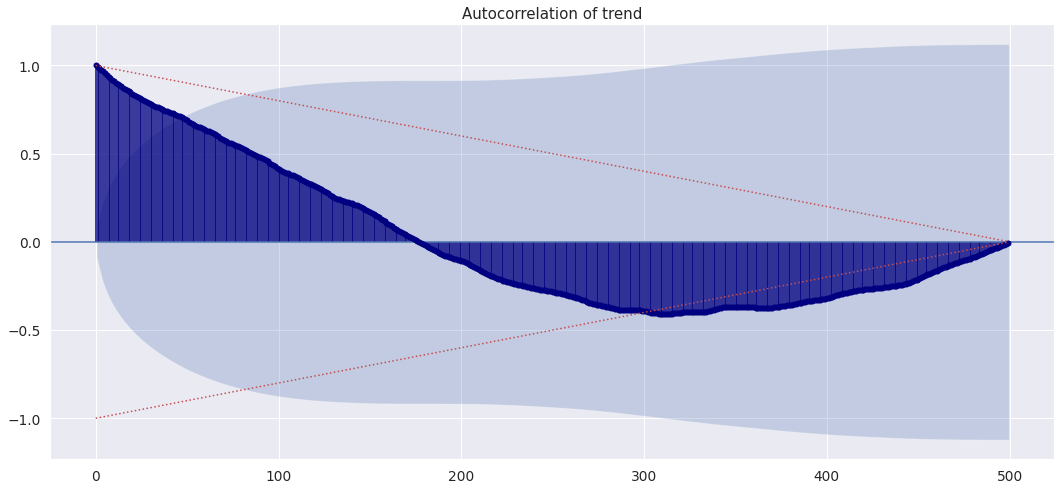

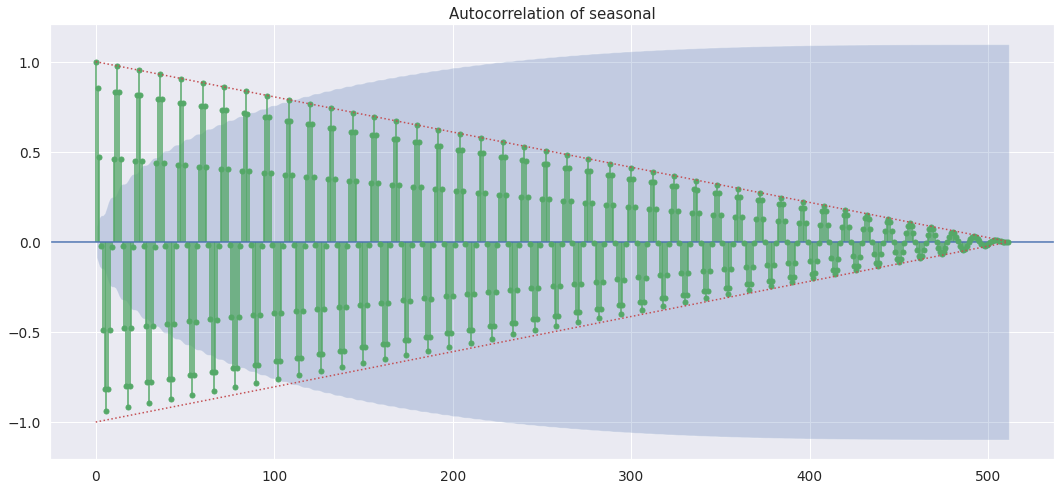

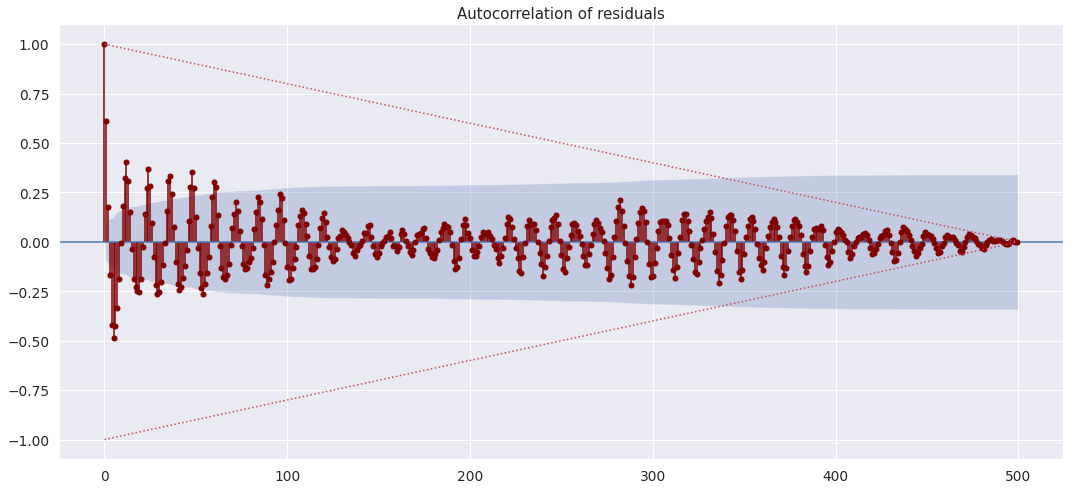

In [ ]:
N = len(data['extent'])
k = np.arange(0, N)
plot_acf(data['extent'], 
         lags=N-1, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend.dropna())
k = np.arange(0, N)
plot_acf(trend.dropna(), 
         lags=N-1, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
k = np.arange(0, N)
plot_acf(seasonal, 
         lags=N-1, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
k = np.arange(0, N)
plot_acf(resid.dropna(), 
         lags=N-1,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

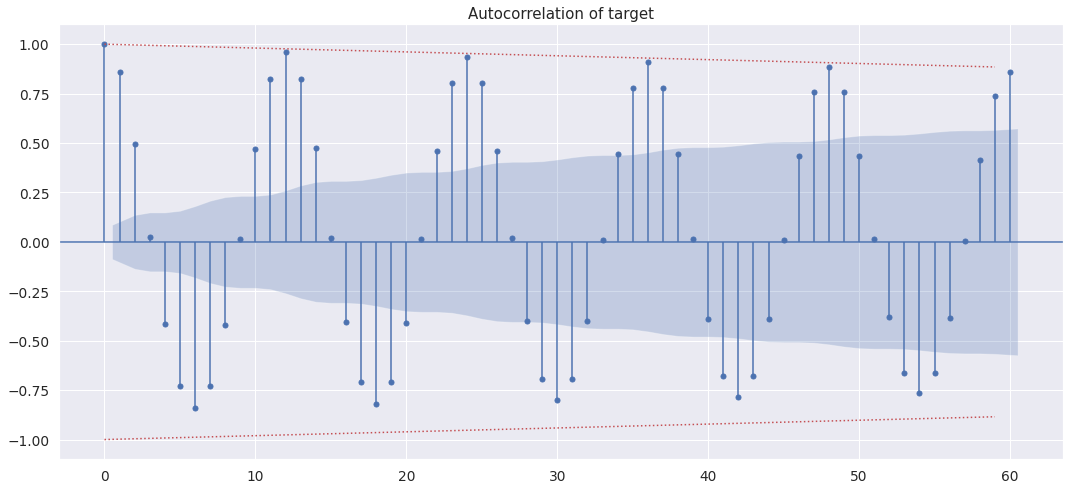

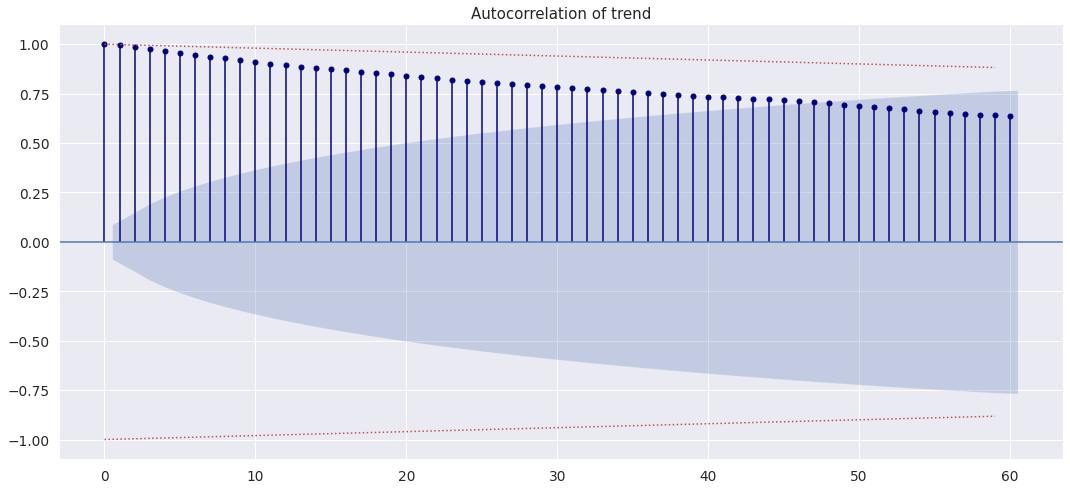

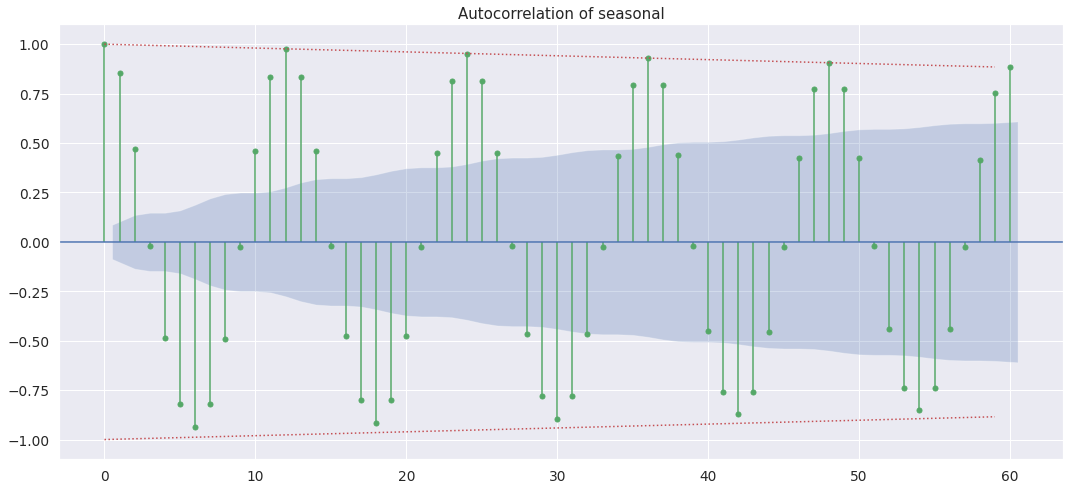

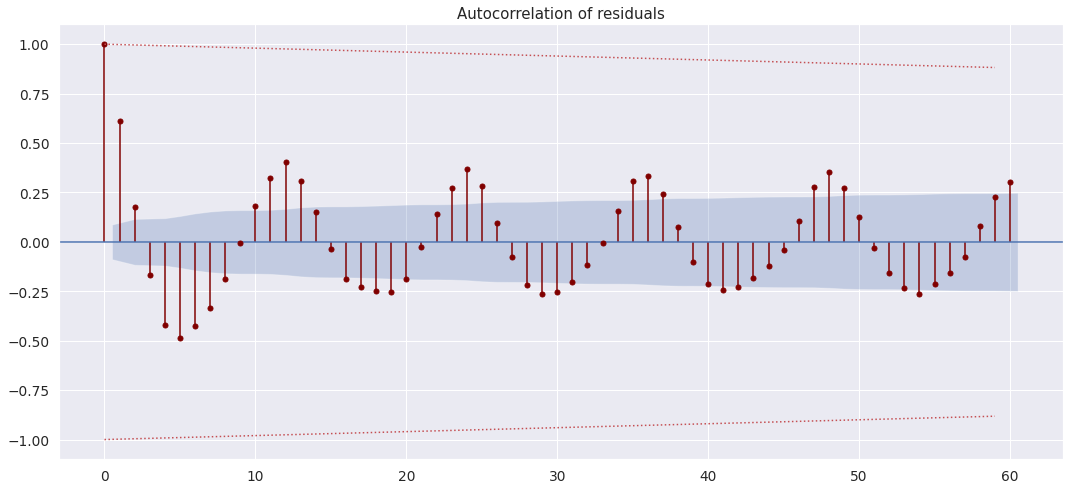

In [ ]:
lags = 60

N = len(data['extent'])
k = np.arange(0, lags)
plot_acf(data['extent'], 
         lags=lags, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Autocorrelation of target');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(trend.dropna())
plot_acf(trend.dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Autocorrelation of trend');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


seasonal = decomposition.seasonal
N = len(seasonal)
plot_acf(seasonal, 
         lags=lags, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Autocorrelation of seasonal');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


N = len(resid.dropna())
plot_acf(resid.dropna(), 
         lags=lags,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Autocorrelation of residuals');
plt.plot(k, 1-k/N, ':r')
plt.plot(k, -1+k/N, ':r')


plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


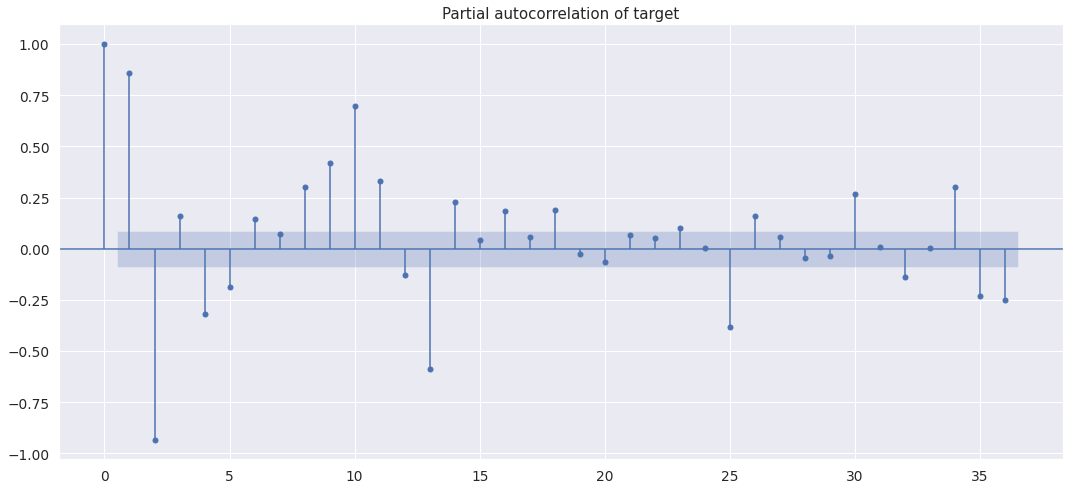

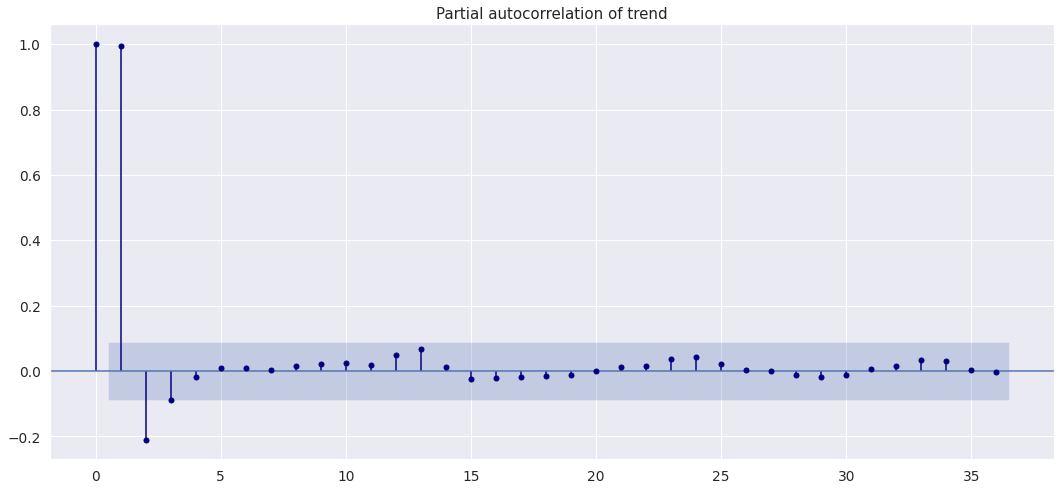

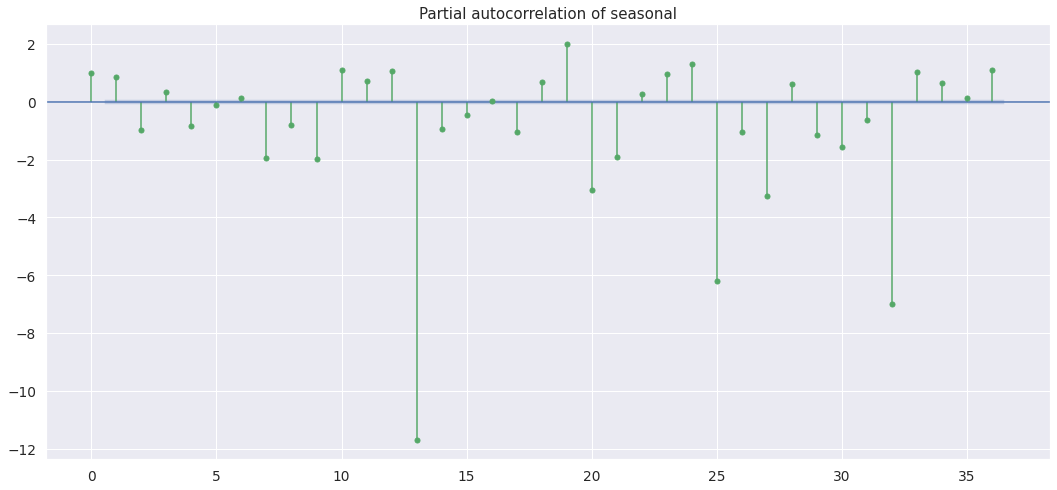

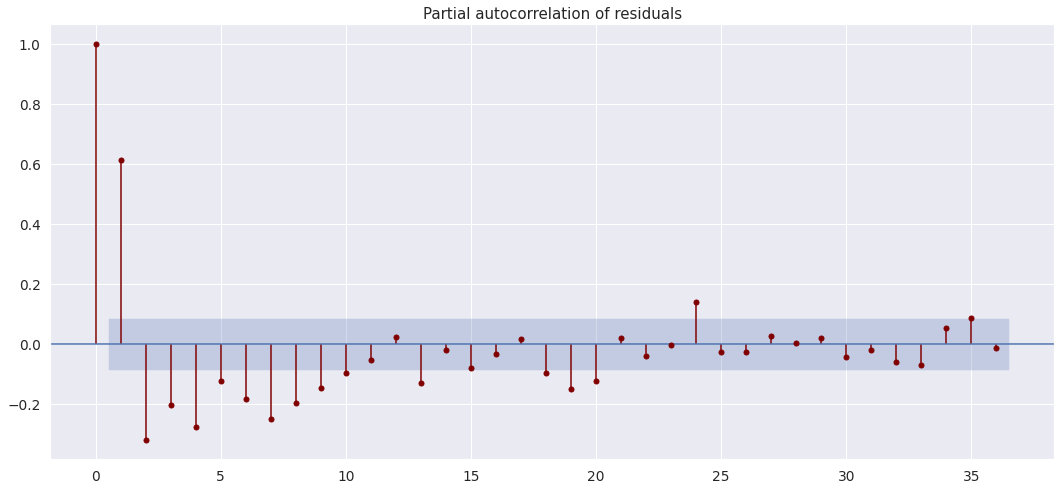

In [ ]:
lags = 36

plot_pacf(data['extent'], 
         lags=lags, 
         vlines_kwargs={'color' : 'b'},
         markerfacecolor='b', markeredgecolor='b', 
         title='Partial autocorrelation of target');
         

plot_pacf(trend.dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of trend');


seasonal = decomposition.seasonal
plot_pacf(seasonal, 
         lags=lags, 
         vlines_kwargs={'color' : 'g'}, 
         markerfacecolor='g', markeredgecolor='g', 
         title='Partial autocorrelation of seasonal');


plot_pacf(resid.dropna(), 
         lags=lags,   
         vlines_kwargs={'color' : 'maroon'}, 
         markerfacecolor='maroon', markeredgecolor='maroon', 
         title='Partial autocorrelation of residuals');


plt.show()

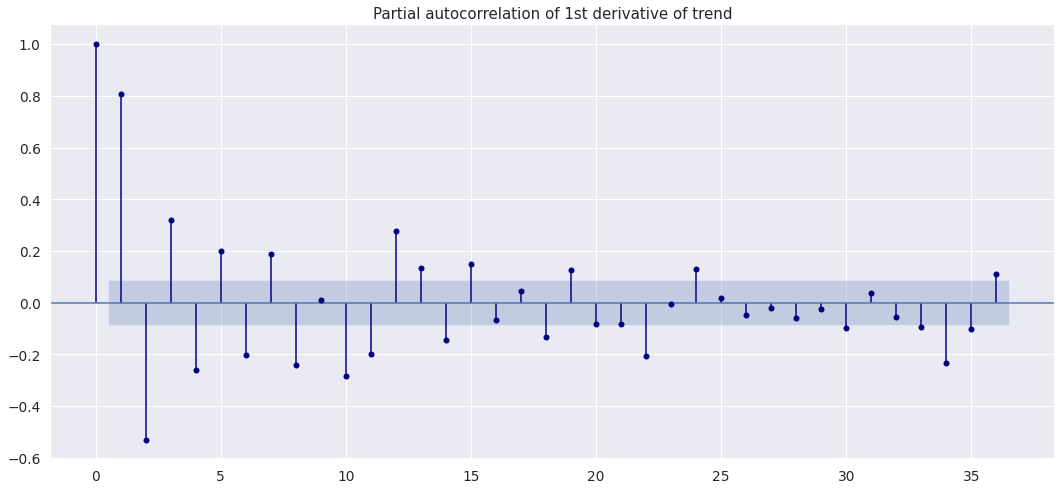

In [ ]:
plot_pacf(trend.dropna().diff().dropna(), 
         lags=lags, 
         vlines_kwargs={'color' : 'navy'}, 
         markerfacecolor='navy', markeredgecolor='navy', 
         title='Partial autocorrelation of 1st derivative of trend');

## Data splitting

In [ ]:
N_test = 60
print(f"we have {len(data)} points totally and last {N_test} test points amongst them.")

train_ind = np.arange(len(data)-N_test)
test_ind = np.arange(len(data)-N_test, len(data))

train = data.iloc[train_ind, :]
test = data.iloc[test_ind, :]

we have 512 points totally and last 60 test points amongst them.


## Forecasting

### Naive approach

Let us obtain seasonal component as determenistic function and fit trend with polynomial (p=2) regression.

In [ ]:
decomposition = seasonal_decompose(train, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal

In [ ]:
def seasonal_component(ind, period=12):
    seasonal_unit = seasonal[:period].values
    ind_norm = ind % period

    return seasonal_unit[ind_norm]

[-5.70291478e-06 -1.86944682e-03  1.23506173e+01]


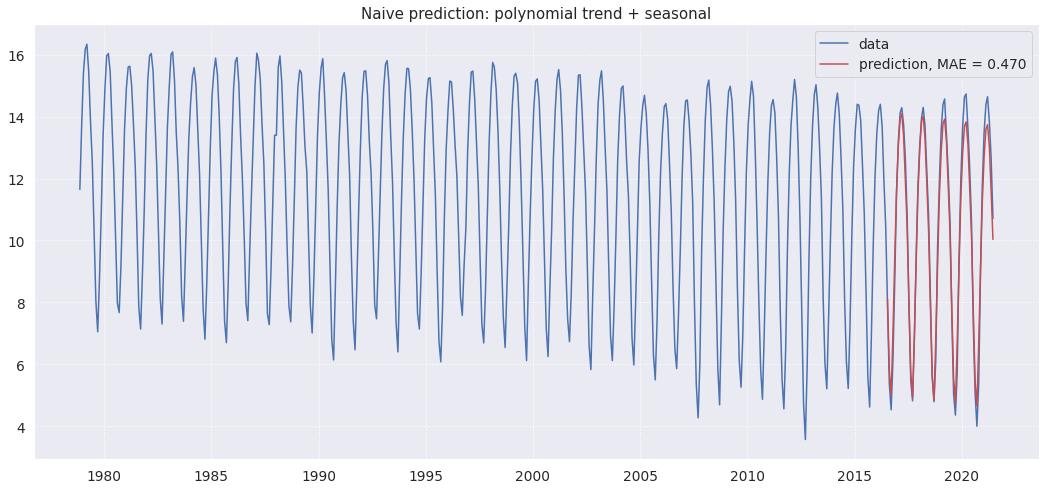

In [ ]:
X_train = trend.reset_index(drop=True).dropna()
X_train_ind = np.array(X_train.index)
y_train = X_train.values

p = np.polyfit(X_train_ind, y_train, 2)
print(p)
trend_pred = np.polyval(p, test_ind)
pred = trend_pred + seasonal_component(test_ind)

mae_naive = mean_absolute_error(test, pred)

plt.plot(data.index, data, '-b', label="data")
plt.plot(test.index, pred, '-r', label=f"prediction, MAE = {mae_naive:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.title("Naive prediction: polynomial trend + seasonal")
plt.show()

## ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('


ARIMA model (12, 1, 12):
ar.L1    -0.145961
ar.L2     0.028731
ar.L3    -0.077555
ar.L4    -0.157179
ar.L5     0.009266
ar.L6    -0.078647
ar.L7    -0.175018
ar.L8     0.031587
ar.L9    -0.084919
ar.L10   -0.151072
ar.L11    0.041047
ar.L12    0.864909
ma.L1     0.169169
ma.L2    -0.378405
ma.L3    -0.245118
ma.L4     0.074533
ma.L5    -0.018008
ma.L6     0.051320
ma.L7     0.142821
ma.L8    -0.101829
ma.L9    -0.134046
ma.L10    0.067588
ma.L11    0.064099
ma.L12   -0.588137
sigma2    0.081098
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


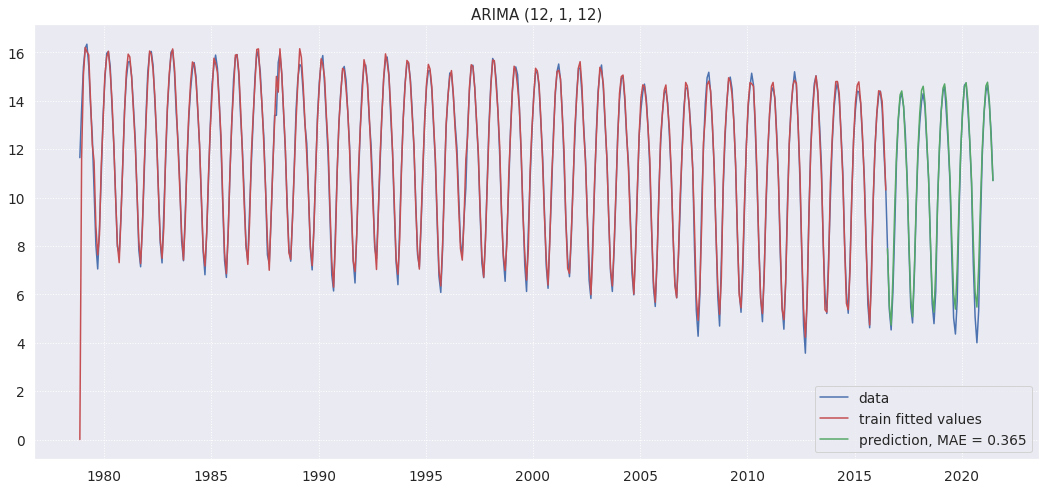

In [ ]:
p, d, q = 12, 1, 12

arima_model = ARIMA(train, order=(p, d, q)).fit()
print()
print(f"ARIMA model ({p}, {d}, {q}):")
print(arima_model.params)

prediction_arima_train = arima_model.predict(train.index[0], train.index[-1])
prediction_arima_test = arima_model.predict(test_ind[0], test_ind[-1])

mae_arima = mean_absolute_error(y_true=test, y_pred=prediction_arima_test)


plt.plot(data.index, data, '-b', label="data")
plt.plot(arima_model.fittedvalues, '-r', label="train fitted values")
plt.plot(test.index, prediction_arima_test, '-g', label=f"prediction, MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':')
plt.legend()
plt.title(f"ARIMA {(p, d, q)}")
plt.show()

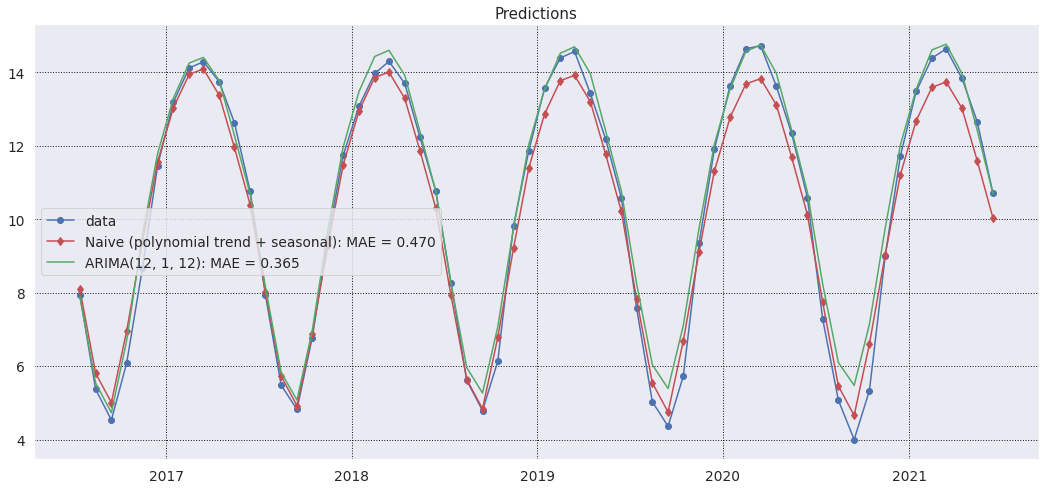

In [ ]:
plt.plot(test.index, test, '-bo', label="data")
plt.plot(test.index, pred, '-rd', label=f"Naive (polynomial trend + seasonal): MAE = {mae_naive:0.3f}")
plt.plot(test.index, prediction_arima_test, '-g', label=f"ARIMA{(p, d, q)}: MAE = {mae_arima:0.3f}")
plt.grid(linestyle=':', color='k')
plt.legend()
plt.title("Predictions")
plt.show()